# 1. Setting up environment
Need datasets for hugging face

In [ ]:
!pip install datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter

from PIL import Image

import os
import copy
from copy import deepcopy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.1 Download Dataset

https://huggingface.co/datasets/microsoft/cats_vs_dogs

In [ ]:
# import zipfile
# with zipfile.ZipFile("cats.zip","r") as zip_ref:
#     zip_ref.extractall()

In [ ]:
# import zipfile
# with zipfile.ZipFile("archive.zip","r") as zip_ref:
#     zip_ref.extractall()

## 2.2 Cats dataset

## 2.3 Transformations

We experimented with several transformations, including different versions of crops and normalizations. The model performance was best when we simply converted pixel values into [0, 1] range and resized the entire image to 256x256 rather than taking a crop of the image.

In [ ]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(256, 256))
])

my_train_dataset = SkyDataset("swimseg-2/train", transforms=transforms)
my_val_dataset = SkyDataset("swimseg-2/val", transforms=transforms)
my_test_dataset = SkyDataset("swimseg-2/test", transforms=transforms)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# swimseg
print(my_train_dataset.__len__())
print(my_val_dataset.__len__())
print(my_test_dataset.__len__())

861
101
51


In [ ]:
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")

# Filter for only cats
cats_ds = ds.filter(lambda example: example['labels'] == 0)

# Split the dataset
splits = cats_ds['train'].train_test_split(test_size=0.2, seed=42)
test_val = splits['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = splits['train']['image']
val_dataset = test_val['train']['image']
test_dataset = test_val['test']['image']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training dataset size: 9392
Validation dataset size: 1174
Test dataset size: 1175


In [ ]:
# train_dataset

In [ ]:
train_dataset[0]

(tensor([[[0.5569, 0.5569, 0.5602,  ..., 0.0935, 0.0906, 0.0941],
          [0.5545, 0.5566, 0.5602,  ..., 0.0915, 0.0903, 0.0917],
          [0.5515, 0.5564, 0.5613,  ..., 0.0900, 0.0889, 0.0902],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5961, 0.5961, 0.5994,  ..., 0.0974, 0.0945, 0.0980],
          [0.5937, 0.5959, 0.5994,  ..., 0.0954, 0.0943, 0.0956],
          [0.5908, 0.5956, 0.6006,  ..., 0.0939, 0.0929, 0.0941],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.6431, 0.6431, 0.6464,  ..., 0.1170, 0.1141, 0.1176],
          [0.6407, 0.6429, 0.6464,  ..., 0.1150, 0.1139, 0.1152],
          [0.6378, 0.6426, 0.6476,  ...,

In [ ]:
class CatDataset(Dataset):
    def __init__(self, all_imgs, transforms=None) -> None:
        super().__init__()
        # self.root_dir = root_dir
        self.transforms = transforms
        self.all_imgs = all_imgs


    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        """
        This method is supposed to return training_img, correct_img. To generate this we do the following

            1) load the image
            2) apply given transforms to the image
            3) create a deep copy of the image which is going to be used as the ground truth image
            4) crop the center (CENTER_CROP_OUT_SIZE, CENTER_CROP_OUT_SIZE)
        """
        # (1) load image
        # img_path = os.path.join(self.root_dir, self.all_imgs[index])
        image = self.all_imgs[index]


        # (2) apply given transforms to the image
        transformed_img = self.transforms(image) if self.transforms else image
        transformed_img = transformed_img[0]


        # (3) create deep copy of image
        ground_truth_image = deepcopy(transformed_img)

        # (4) crop the center
        #       an assumption here is that the image is 256x256 which is true because we constructed the transforms
        transformed_img[:, 10:20, 10:20] = torch.rand((3, 10, 10))
        # transformed_img[:, 96:160, 96:160] = torch.rand((3, 64, 64))


        return transformed_img, ground_truth_image

In [ ]:
transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(size=(64, 64))
])

my_train_dataset = CatDataset(train_dataset, transforms=transforms)
# my_val_dataset = CatDataset(val_dataset, transforms=transforms)
# my_test_dataset = CatDataset("swimseg-2/test", transforms=transforms)

## 2.4 Explore Dataset

In [ ]:
my_train_dataset[0]

(Image([[[0.5569, 0.5569, 0.5602,  ..., 0.0935, 0.0906, 0.0941],
         [0.5545, 0.5566, 0.5602,  ..., 0.0915, 0.0903, 0.0917],
         [0.5515, 0.5564, 0.5613,  ..., 0.0900, 0.0889, 0.0902],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
        [[0.5961, 0.5961, 0.5994,  ..., 0.0974, 0.0945, 0.0980],
         [0.5937, 0.5959, 0.5994,  ..., 0.0954, 0.0943, 0.0956],
         [0.5908, 0.5956, 0.6006,  ..., 0.0939, 0.0929, 0.0941],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
        [[0.6431, 0.6431, 0.6464,  ..., 0.1170, 0.1141, 0.1176],
         [0.6407, 0.6429, 0.6464,  ..., 0.1150, 0.1139, 0.1152],
         [0.6378, 0.6426, 0.6476,  ..., 0.1133, 0.1111, 

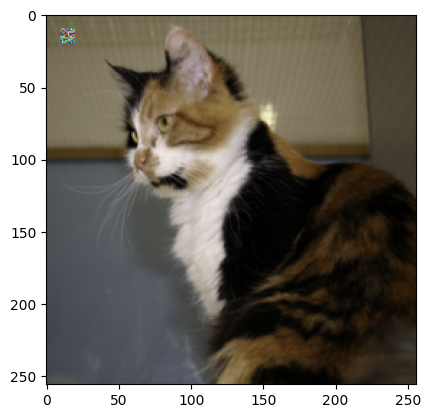

In [ ]:
plt.imshow(np.transpose(my_train_dataset[0][0], (1, 2, 0)))

In [ ]:
item0, item1, item2 = my_train_dataset[10], my_train_dataset[1], my_train_dataset[2]

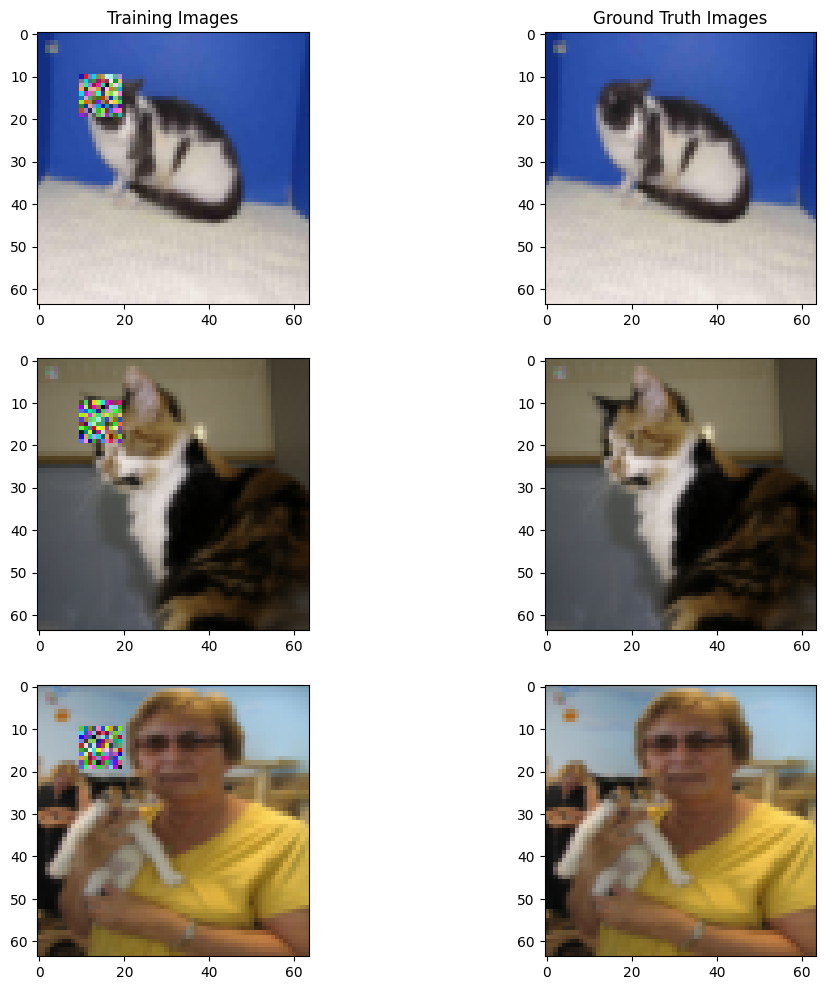

In [ ]:
# train image
f, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(np.transpose(item0[0], (1, 2, 0)))
ax[0, 1].imshow(np.transpose(item0[1], (1, 2, 0)))
ax[1, 0].imshow(np.transpose(item1[0], (1, 2, 0)))
ax[1, 1].imshow(np.transpose(item1[1], (1, 2, 0)))
ax[2, 0].imshow(np.transpose(item2[0], (1, 2, 0)))
ax[2, 1].imshow(np.transpose(item2[1], (1, 2, 0)))

ax[0, 0].set_title("Training Images");
ax[0, 1].set_title("Ground Truth Images");


## 2.5 Setup Dataloader

In [ ]:
train_dataset, val_dataset, test_dataset = my_train_dataset, my_val_dataset, my_test_dataset

In [ ]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)